## Group Members
- Edward Brovkin - 2406832
- Momina Iffat Iftikhar - 2412443
- Muhammad Junaid Raza - 2409917

## Disclaimer
After writing analysis and summary for signal visualisation, model performance reporting before and after LOO-CV, I have used Grammerly AI to **rephrase the summary**. 

## Code References
- https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html
- https://www.geeksforgeeks.org/understanding-logistic-regression/
- https://github.com/KhaledAshrafH/Logistic-Regression
- https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html
- https://www.geeksforgeeks.org/random-forest-regression-in-python/
- https://www.datacamp.com/tutorial/random-forests-classifier-python
- https://stackoverflow.com/questions/3207219/how-do-i-list-all-files-of-a-directory
- https://www.geeksforgeeks.org/python-list-files-in-a-directory/
- https://github.com/junaidraz1/leave-one-out-validation
- https://www.geeksforgeeks.org/loocvleave-one-out-cross-validation-in-r-programming/
- https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.LeaveOneOut.html

## Import Libraries

In [33]:
# standard libraries
import os            
import random            
import numpy as np       
import pandas as pd    

# data visualization
import seaborn as sns                    
import matplotlib.pyplot as plt          

# signal processing
import scipy.signal as signal            
from scipy.signal import butter, filtfilt 
from scipy.fft import fft                
import scipy.stats as stats             
from scipy.stats import skew            

# utility
from pprint import pprint              

# machine learning models & evaluation        
from sklearn.metrics import (                    
    confusion_matrix, 
    accuracy_score, 
    precision_score, 
    recall_score, 
    f1_score, 
    classification_report
)

from sklearn.model_selection import LeaveOneOut          
from sklearn.model_selection import train_test_split     
from sklearn.preprocessing import StandardScaler         
from sklearn.linear_model import LogisticRegression      
from sklearn.ensemble import RandomForestClassifier     

## Loading and visualising data

Printing and Visualizing Normal Signal: subj_32.csv
First few rows of the data:
         time     s1     s2     s3
0  '0:00.000'  0.027  0.022 -0.165
1  '0:00.050'  0.042  0.023 -0.172
2  '0:00.100'  0.042  0.022 -0.173
3  '0:00.150'  0.038  0.014 -0.168
4  '0:00.200'  0.041  0.010 -0.171


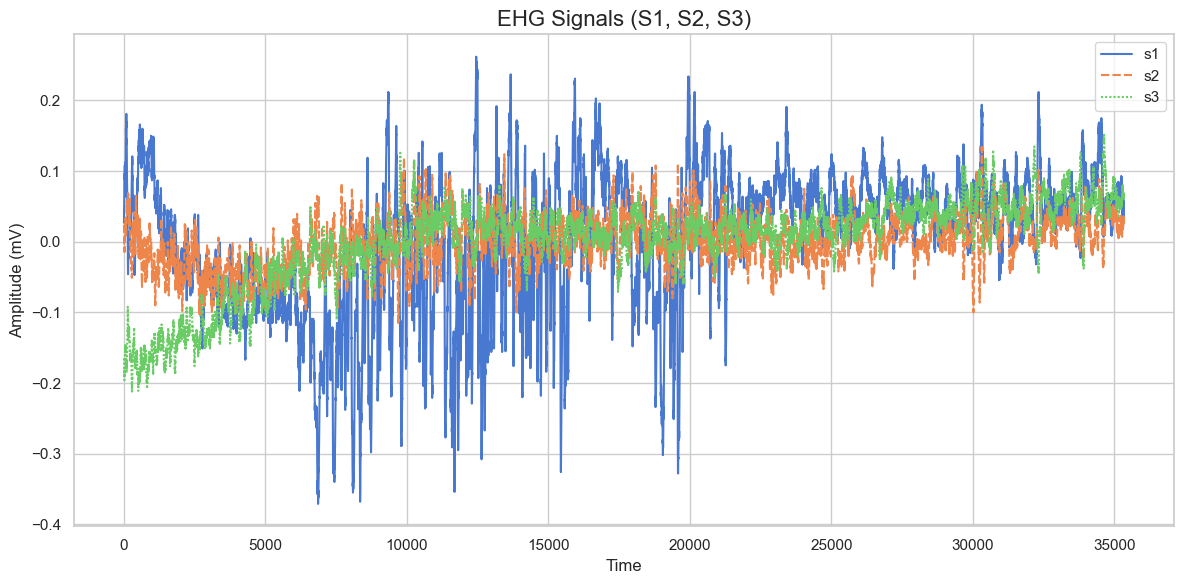

Printing and Visualizing Preterm Signal: subj_2.csv
First few rows of the data:
         time     s1     s2     s3
0  '0:00.000'  0.121  0.265  0.065
1  '0:00.050'  0.121  0.263  0.063
2  '0:00.100'  0.119  0.261  0.061
3  '0:00.150'  0.122  0.262  0.057
4  '0:00.200'  0.118  0.261  0.059


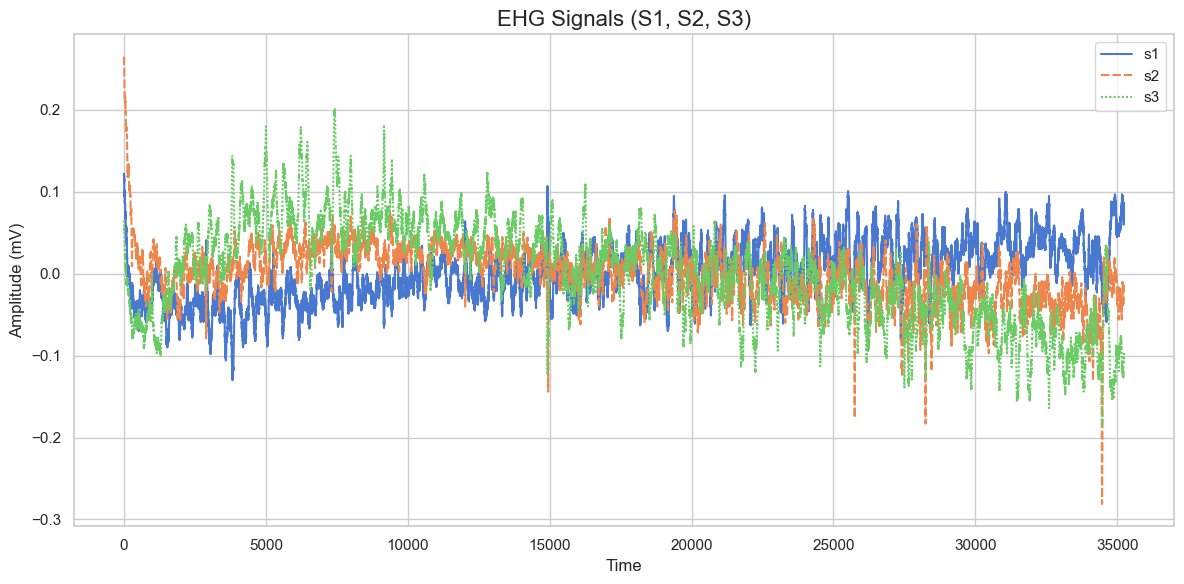

In [35]:
def load_show_data(file_path):
    # loading data
    data = pd.read_csv(file_path)
    
    # printing the first few rows of the data to inspect it
    print("First few rows of the data:")
    print(data.head())

    sns.set(style="whitegrid")
    
    plt.figure(figsize=(12, 6))
    sns.lineplot(data=data[['s1', 's2', 's3']], palette='muted')
    plt.title('EHG Signals (S1, S2, S3)', fontsize=16)
    plt.xlabel('Time', fontsize=12)
    plt.ylabel('Amplitude (mV)', fontsize=12)
    plt.tight_layout()
    plt.show()

# loading all files from the normal and preterm folders
normal_folder = 'data/normal/'
preterm_folder = 'data/preterm/'

normal_files = os.listdir(normal_folder)  
preterm_files = os.listdir(preterm_folder)  

# randomly selecting one file from each folder to display (because displaying all of them takes time)
random_normal_file = random.choice(normal_files)
random_preterm_file = random.choice(preterm_files)

# file paths
normal_signal = os.path.join(normal_folder, random_normal_file)
preterm_signal = os.path.join(preterm_folder, random_preterm_file)

print(f"Printing and Visualizing Normal Signal: {random_normal_file}")
load_show_data(normal_signal)

print(f"Printing and Visualizing Preterm Signal: {random_preterm_file}")
load_show_data(preterm_signal)

**Summary:**
- First graph displays normal signals across three channels i.e S1, S2, S3. The blue S1 channel shows dramatically larger fluctuations than the other channels, particularly in the middle section with peaks.
- Second graph shows preterm signals and the overall signal has smaller amplitude variations compared to the normal signals. It demonstrates less organized patterns with irregular fluctuations. Channel dominance shifts throughout the recording, with S3 more active early on and S1 becoming more prominent later. The signal appears to have higher frequency components and less synchronization between channels.

## Step 1: Loading the data and applying preprocessing techniques on it

Randomly selected normal signal file: subj_6.csv
Randomly selected preterm signal file: subj_16.csv
Printing and Visualizing Normal Signal
First few rows of the data:
   time        s1        s2        s3
0  0.00  0.000267 -0.000120 -0.000260
1  0.05 -0.000876  0.000166  0.000082
2  0.10 -0.001924  0.000443  0.000420
3  0.15 -0.002776  0.000707  0.000729
4  0.20 -0.003365  0.000964  0.000991


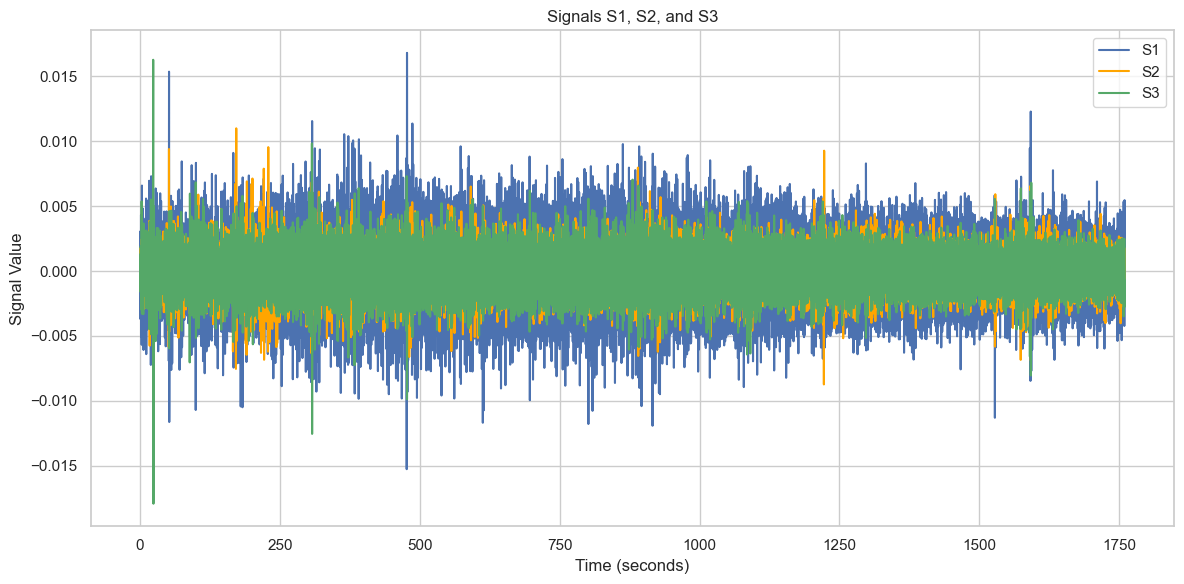

Printing and Visualizing Preterm Signal
First few rows of the data:
   time        s1        s2        s3
0  0.00  0.000142 -0.007686 -0.008538
1  0.05  0.000742 -0.001372 -0.007058
2  0.10  0.001144  0.004222 -0.005376
3  0.15  0.001241  0.008376 -0.003578
4  0.20  0.001047  0.010763 -0.001778


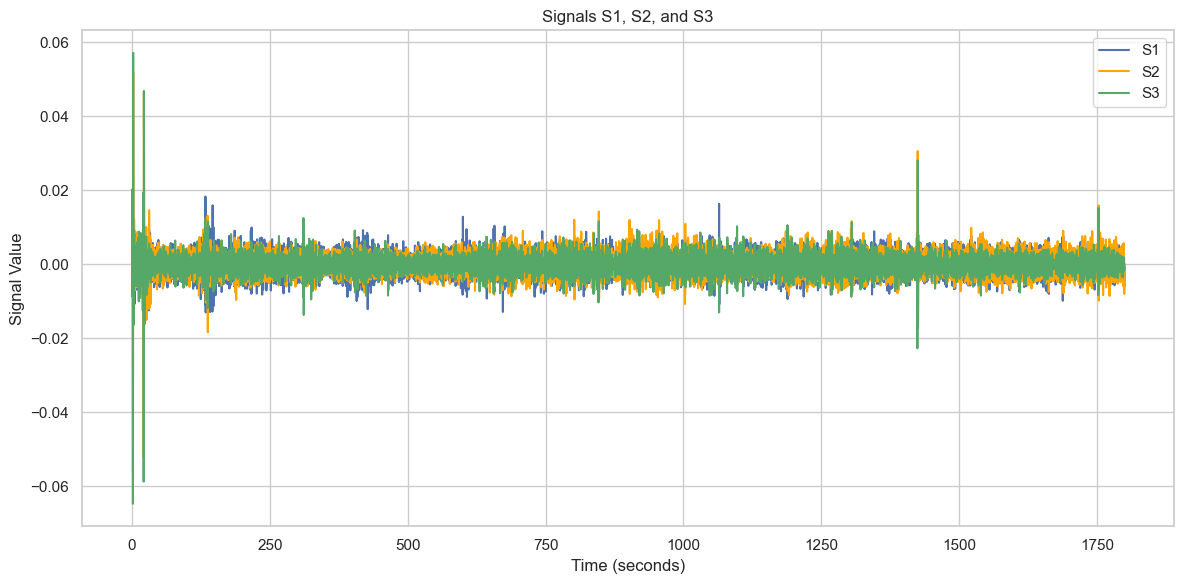

In [41]:
# method to preprocess data and visualise it after removing noise 
def preprocess_data(file_path):
    # loading the data
    data = pd.read_csv(file_path)
    
    # cleaning and convertnig the 'time' column
    data['time'] = data['time'].str.replace("'", "")
    def convert_to_seconds(time_str):
        try:
            # spliting the time into minutes, seconds, and milliseconds
            minutes, rest = time_str.split(':')
            seconds, milliseconds = rest.split('.')
            
            # converting each part to an integer and calculate total seconds
            total_seconds = int(minutes) * 60 + int(seconds) + int(milliseconds) / 1000
        except ValueError:
            total_seconds = np.nan  
        return total_seconds
    
    data['time'] = data['time'].apply(convert_to_seconds)
    data['time'] = pd.to_numeric(data['time'], errors='coerce')

    # applying band-pass filter with sample frequency of 20hz with lowcut and highcut frequency of 0.5 & 2 Hz respectively for all three signals (s1, s2, s3)
    fs = 20 
    lowcut = 0.5 
    highcut = 2 
    
    # creating filter
    nyquist = 0.5 * fs
    low = lowcut / nyquist
    high = highcut / nyquist
    b, a = signal.butter(4, [low, high], btype='band')

    # applying the filter to each signal (s1, s2, s3)
    data['s1'] = signal.filtfilt(b, a, data['s1'])
    data['s2'] = signal.filtfilt(b, a, data['s2'])
    data['s3'] = signal.filtfilt(b, a, data['s3'])

    return data

# method to load and visualize the data
def show_preprocess_data(file_path):
    data = preprocess_data(file_path)
    
    print("First few rows of the data:")
    print(data.head())

    plt.figure(figsize=(12, 6))
    sns.lineplot(x=data['time'], y=data['s1'], label='S1', color='b')
    sns.lineplot(x=data['time'], y=data['s2'], label='S2', color='orange')
    sns.lineplot(x=data['time'], y=data['s3'], label='S3', color='g')
    plt.title('Signals S1, S2, and S3')
    plt.xlabel('Time (seconds)')
    plt.ylabel('Signal Value')
    plt.legend()
    plt.tight_layout()
    plt.show()

normal_data_dir = 'data/normal/'
preterm_data_dir = 'data/preterm/'

normal_files = os.listdir(normal_data_dir)
preterm_files = os.listdir(preterm_data_dir)

# selecting a random file from each folder again for the visualisation because of performance issues
random_normal_file = random.choice(normal_files)
random_preterm_file = random.choice(preterm_files)

print(f"Randomly selected normal signal file: {random_normal_file}")
print(f"Randomly selected preterm signal file: {random_preterm_file}")

normal_signal = os.path.join(normal_data_dir, random_normal_file)
preterm_signal = os.path.join(preterm_data_dir, random_preterm_file)

print("Printing and Visualizing Normal Signal")
show_preprocess_data(normal_signal)

print("Printing and Visualizing Preterm Signal")
show_preprocess_data(preterm_signal)

**Summary:**
- The frist graph which is of preprocessed normal signal shows significantly reduced noise with clear rhythmic patterns. The bandpass filter has removed baseline drift and high-frequency artifacts. Channel S1 (blue) still shows more pronounced activity throughout the recording with consistent, moderate fluctuations. The early spike in S3 (green) near the beginning likely represents an initial artifact that wasn't fully eliminated by filtering since it falls within the passband frequency range of interest.
- The second graph which is preprocessed preterm signal demonstrates more dramatic changes from filtering, with amplitude scale now approximately 4 times larger than the normal signal. The bandpass filter has isolated key frequency components while removing noise, revealing distinct temporal patterns. The prominent S3 spike at the beginning and the S2 spike around 1400 seconds represent significant artifact events that fall within the defined frequency band. These large-amplitude events, preserved after filtering might serve as important discriminative features for classification.

## Step 2: Extracting features and displaying in a readable format

In [74]:
def print_features(signal_type, s1_features, s2_features, s3_features):
    print(f"--- {signal_type} Signal Features ---")
    
    print(f"S1 Features:")
    for feature, value in s1_features.items():
        print(f"  {feature.capitalize()}: {value:.4f}")
    
    print(f"\nS2 Features:")
    for feature, value in s2_features.items():
        print(f"  {feature.capitalize()}: {value:.4f}")
        
    print(f"\nS3 Features:")
    for feature, value in s3_features.items():
        print(f"  {feature.capitalize()}: {value:.4f}")
    
    print("\n")

# method to extract features from a signal
def extract_features(data, signal_column):
    signal_data = data[signal_column]

    features = {}

    # Time-domain features
    features['mean'] = np.mean(signal_data)
    features['std'] = np.std(signal_data)
    features['rms'] = np.sqrt(np.mean(np.square(signal_data)))
    features['max'] = np.max(signal_data)
    features['min'] = np.min(signal_data)
    features['skewness'] = stats.skew(signal_data)
    features['kurtosis'] = stats.kurtosis(signal_data)
    
    # Frequency-domain features
    freqs, psd = signal.welch(signal_data, fs=20)  # 20 Hz sample frequency
    dominant_freq_idx = np.argmax(psd)
    features['resonance_frequency'] = freqs[dominant_freq_idx]
    
    psd_normalized = psd / np.sum(psd)  # Normalize the PSD
    spectral_entropy = -np.sum(psd_normalized * np.log2(psd_normalized + 1e-12))  # Avoid log(0)
    features['spectral_entropy'] = spectral_entropy

    return features

normal_data = preprocess_data(normal_signal)
preterm_data = preprocess_data(preterm_signal)

# extracting features for s1, s2, s3 from both normal and preterm signals
normal_s1_features = extract_features(normal_data, 's1')
normal_s2_features = extract_features(normal_data, 's2')
normal_s3_features = extract_features(normal_data, 's3')

preterm_s1_features = extract_features(preterm_data, 's1')
preterm_s2_features = extract_features(preterm_data, 's2')
preterm_s3_features = extract_features(preterm_data, 's3')

print_features("Normal", normal_s1_features, normal_s2_features, normal_s3_features)
print_features("Preterm", preterm_s1_features, preterm_s2_features, preterm_s3_features)

--- Normal Signal Features ---
S1 Features:
  Mean: 0.0000
  Std: 0.0032
  Rms: 0.0032
  Max: 0.0168
  Min: -0.0153
  Skewness: -0.0085
  Kurtosis: -0.2511
  Resonance_frequency: 1.2500
  Spectral_entropy: 3.4513

S2 Features:
  Mean: 0.0000
  Std: 0.0017
  Rms: 0.0017
  Max: 0.0110
  Min: -0.0087
  Skewness: 0.0600
  Kurtosis: 0.8955
  Resonance_frequency: 0.5469
  Spectral_entropy: 3.8453

S3 Features:
  Mean: -0.0000
  Std: 0.0018
  Rms: 0.0018
  Max: 0.0163
  Min: -0.0179
  Skewness: -0.0535
  Kurtosis: 1.7056
  Resonance_frequency: 1.2500
  Spectral_entropy: 3.6427


--- Preterm Signal Features ---
S1 Features:
  Mean: -0.0000
  Std: 0.0026
  Rms: 0.0026
  Max: 0.0170
  Min: -0.0165
  Skewness: 0.0254
  Kurtosis: 2.1371
  Resonance_frequency: 0.6250
  Spectral_entropy: 3.7613

S2 Features:
  Mean: 0.0000
  Std: 0.0033
  Rms: 0.0033
  Max: 0.0339
  Min: -0.0601
  Skewness: -0.7012
  Kurtosis: 18.1536
  Resonance_frequency: 0.6250
  Spectral_entropy: 3.3491

S3 Features:
  Mean: 0.0

**Summary:**
- **Comparison of S1 channel – Normal vs Preterm:** <br>
The normal S1 signal shows a very low mean with a standard deviation and RMS of 0.0032, indicating minimal variability. The amplitude stays within a tight range, with a nearly symmetric distribution and slight platykurtosis, suggesting light tails. In contrast, the preterm S1 signal shows reduced variability with standard deviation and RMS of 0.0026 and similar amplitude but increased kurtosis, implying a heavier-tailed distribution. The shift in resonance frequency indicates a possible slowdown in rhythmic patterns, while a rise in spectral entropy suggests greater signal complexity or unpredictability in preterm cases.
- **Comparison of S2 channel – Normal vs Preterm:** <br>
The normal S2 signal is characterized by a very low mean and a stable signal with standard deviation and RMS of 0.0017 and modest amplitude with near-zero skewness. Its kurtosis indicates a distribution close to normal. However, in the preterm signal, S2 has much higher variability with standard deviation and RMS of 0.0033 and a dramatic increase in kurtosis, pointing to a highly peaked and heavy-tailed distribution. The skewness indicates left-skewed outliers. Additionally, spectral entropy decreases implying reduced signal randomness or more repetitive patterns, possibly due to pathological rhythmic contractions. The resonance frequency also drops to 0.6250 Hz.
- **Comparison of S3 channel – Normal vs Preterm:** <br>
The normal S3 signal maintains a low mean and relatively consistent variability with standard deviation and RMS of 0.0018. It has balanced amplitude spread and a slight negative skew. The kurtosis suggests a moderately heavier tail than a normal distribution. For the preterm S3, the variability decreases slightly with standard deviation and RMS of 0.0024, but both kurtosis and amplitude range increase, indicating stronger peaks and more extreme values. The spectral entropy remains relatively stable but the resonance frequency drops showing a potential reduction in the frequency of signal oscillations.

## Step 3: Preparing Data for Model
Selected supervised machine learning algorithms are:
- **Logistic Regression**
- **Random Forest**

## Why?
- The first machine learning algorithm that I chose **Logistic Regression** as a baseline classifier due to its simplicity, robustness, and suitability for binary classification tasks like this, where the goal is to distinguish between preterm (1) and normal (0) pregnancies. Given the small dataset size, this algorithm helps avoid overfitting and provides interpretable coefficients, making it easier to understand which features from the EHG signals contribute most to the classification decision.
- The second one is **Random Forest**, used to capture potential non-linear patterns and interactions between features that Logistic Regression might miss since EHG signals are complex and may contain subtle patterns across channels that are not linearly separable. This algorithm, being an ensemble of decision trees, handles such complexity well and is also relatively robust to overfitting—even on small datasets—due to its averaging mechanism. This makes it a strong candidate to model more complicated relationships within the EHG-derived features.

In [157]:
# listing all files in the folders
normal_files = [f for f in os.listdir(normal_folder) if not f.startswith('.')]
preterm_files = [f for f in os.listdir(preterm_folder) if not f.startswith('.')]

# initializing lists to store features and labels
X = []  
y = []  

# extracting features for normal files (label = 0)
for file in normal_files:
    file_path = os.path.join(normal_folder, file)
    data = preprocess_data(file_path)
    
    # extracting features for s1, s2, and s3 signals
    features_s1 = extract_features(data, 's1')
    features_s2 = extract_features(data, 's2')
    features_s3 = extract_features(data, 's3')
    
    # combining features into a single vector
    features = {**features_s1, **features_s2, **features_s3}
    
    # appending features and label to the lists
    X.append(list(features.values()))
    y.append(0)  # Normal label

# extracting features for preterm files (label = 1)
for file in preterm_files:
    file_path = os.path.join(preterm_folder, file)
    data = preprocess_data(file_path)
    
    # extracting features for s1, s2, and s3 signals
    features_s1 = extract_features(data, 's1')
    features_s2 = extract_features(data, 's2')
    features_s3 = extract_features(data, 's3')
    
    # combining features into a single vector
    features = {**features_s1, **features_s2, **features_s3}
    
    # appending features and label to the lists
    X.append(list(features.values()))
    y.append(1)  # Preterm label

X = np.array(X)
y = np.array(y)

# standardizing the features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# data split into training and testing sets (80% training, 20% testing)
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

# initializing the classifiers
logreg = LogisticRegression()
rf = RandomForestClassifier(n_estimators=100, random_state=42)

# training the Logistic Regression classifier
logreg.fit(X_train, y_train)
y_pred_logreg = logreg.predict(X_test)

# training the Random Forest classifier
rf.fit(X_train, y_train)
y_pred_rf = rf.predict(X_test)

# evaluating the classifiers' accuracy
logreg_accuracy = accuracy_score(y_test, y_pred_logreg)
rf_accuracy = accuracy_score(y_test, y_pred_rf)

print("Logistic Regression Evaluation:")
print(f"\nAccuracy: {logreg_accuracy * 100:.2f}%")
print("Classification Report:")
print(classification_report(y_test, y_pred_logreg))

print("-"*60)

print("Random Forest Evaluation:")
print(f"\nAccuracy: {rf_accuracy * 100:.2f}%")
print("Classification Report:")
print(classification_report(y_test, y_pred_rf))

Logistic Regression Evaluation:

Accuracy: 87.50%
Classification Report:
              precision    recall  f1-score   support

           0       0.75      1.00      0.86         3
           1       1.00      0.80      0.89         5

    accuracy                           0.88         8
   macro avg       0.88      0.90      0.87         8
weighted avg       0.91      0.88      0.88         8

------------------------------------------------------------
Random Forest Evaluation:

Accuracy: 75.00%
Classification Report:
              precision    recall  f1-score   support

           0       0.67      0.67      0.67         3
           1       0.80      0.80      0.80         5

    accuracy                           0.75         8
   macro avg       0.73      0.73      0.73         8
weighted avg       0.75      0.75      0.75         8



**Model Performance Summary:** <br>
- Logistic Regression outperformed Random Forest in this classification task. It achieved an accuracy of 87.50%, with a strong precision of 1.00 and recall of 0.80 for preterm cases, indicating it correctly identified most preterm samples without many false positives. Its high F1-score (0.89) for the preterm class shows a good balance between precision and recall.
- Random Forest achieved a lower accuracy of 75.00%, with a slightly less balanced performance, F1-score of 0.80 for preterm. While it did reasonably well, the drop in accuracy and the macro/weighted averages indicate that Logistic Regression is currently the more reliable choice on this dataset, possibly due to the limited sample size where simpler models tend to generalize better.

## Step 4: Evaluating the two classifiers using leave-one-out cross-validation

### 4 (a): Leave-One-Out Cross-Validation Setup

In [147]:
# creating a Leave-One-Out Cross-Validation (LOO-CV) object
loo = LeaveOneOut()

log_reg_model = LogisticRegression()
rf_model = RandomForestClassifier(n_estimators=100)

# initializing lists to store the results
log_reg_predictions = []
rf_predictions = []
log_reg_true_labels = []
rf_true_labels = []

### 4 (b): Standardize features inside the loop

In [149]:
scaler = StandardScaler()

# looping through each sample for LOO-CV
for train_index, test_index in loo.split(X):
    # spliting data into training and testing sets
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]

    # standardizing the features
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)

    # training the logistic regression model
    log_reg_model.fit(X_train_scaled, y_train)
    log_reg_pred = log_reg_model.predict(X_test_scaled)
    
    # training the random forest model
    rf_model.fit(X_train_scaled, y_train)
    rf_pred = rf_model.predict(X_test_scaled)

    # storing the predictions and true labels
    log_reg_predictions.append(log_reg_pred)
    rf_predictions.append(rf_pred)
    log_reg_true_labels.append(y_test)
    rf_true_labels.append(y_test)

### 4 (c): Applying LOO-CV and obtaining classification report

In [150]:
log_reg_acc = accuracy_score(log_reg_true_labels, log_reg_predictions)

print("Logistic Regression Evaluation:")
print(f"\nAccuracy: {log_reg_acc * 100:.2f}%")
print("Classification Report:")
print(classification_report(log_reg_true_labels, log_reg_predictions))

print("-"*60)

rf_acc = accuracy_score(rf_true_labels, rf_predictions)

print("Random Forest Evaluation:")
print(f"\nAccuracy: {rf_acc * 100:.2f}%")
print("Classification Report:")
print(classification_report(rf_true_labels, rf_predictions))

Logistic Regression Evaluation:

Accuracy: 71.05%
Classification Report:
              precision    recall  f1-score   support

           0       0.72      0.68      0.70        19
           1       0.70      0.74      0.72        19

    accuracy                           0.71        38
   macro avg       0.71      0.71      0.71        38
weighted avg       0.71      0.71      0.71        38

------------------------------------------------------------
Random Forest Evaluation:

Accuracy: 57.89%
Classification Report:
              precision    recall  f1-score   support

           0       0.57      0.63      0.60        19
           1       0.59      0.53      0.56        19

    accuracy                           0.58        38
   macro avg       0.58      0.58      0.58        38
weighted avg       0.58      0.58      0.58        38



### Model performance summary after applying LOO-CV
- Before applying LOOCV, Logistic Regression achieved an accuracy of 87.50% with perfect recall for the normal class and strong precision for the preterm class, indicating effective separation between the two categories. However, when evaluated using LOOCV, which provides a more robust measure of generalization on smaller datasets, the accuracy dropped to 71.05%. Despite the decrease, the model maintained balanced precision and recall across both classes (normal and preterm), with an F1-score of 0.70 and 0.72, respectively. This suggests that while Logistic Regression performs well on isolated splits, its true generalization ability is more modest but still reasonable in the context of this classification task.
- In contrast, the Random Forest classifier initially demonstrated an accuracy of 75.00% on the test set, which was already lower than that of Logistic Regression. After applying LOOCV, its performance further declined to 57.89% accuracy. The classification report revealed inconsistent precision and recall between the two classes, and a noticeable imbalance in correctly predicting preterm vs. normal cases. The F1-scores of 0.60 for normal and 0.56 for preterm indicate that the model struggled to generalize reliably across the dataset. This decline highlights Random Forest’s sensitivity to small datasets and suggests overfitting on the initial split, making it less suitable for this scenario compared to Logistic Regression.